<a href="https://colab.research.google.com/github/scrollingdown/cafegaussiano/blob/main/PI_V_bayesiano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import pymc as pm
import pytensor.tensor as tt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

pasta_datasets = '/content/drive/My Drive/ANTAQ'

arquivos = os.listdir(pasta_datasets)
print(arquivos)

['df_cargas_santos_filtrado.csv', '2019TemposAtracacao.txt', 'Instalacao_Origem.txt', 'cafe_jan2010_ate_jul2024.db', 'MercadoriaConteinerizada.txt', 'Instalacao_Destino.txt', '2018TemposAtracacao.txt', '2020Atracacao.txt', '2022Atracacao.txt', '2020TemposAtracacao.txt', '2019Atracacao.txt', '2021TemposAtracacao.txt', '2018Atracacao.txt', '2021Atracacao.txt', '2018Carga_Conteinerizada.txt', '2019Carga_Conteinerizada.txt', '2022Carga_Conteinerizada.txt', '2020Carga_Conteinerizada.txt', '2021Carga_Conteinerizada.txt', '2023Atracacao.txt', '2019Carga.txt', '2022Carga.txt', 'df_cargas_brasil.csv', '2021Carga.txt', '2023Carga.txt', 'df_cargas_brasil2.csv', '2020Carga.txt', '2018Carga.txt', 'df_santos_coffee_no_duplicates.csv', 'df_santos_coffee.csv']


In [ ]:
caminho_arquivo = f'{pasta_datasets}/df_santos_coffee.csv'
df_oficial = pd.read_csv(caminho_arquivo, encoding='latin-1')

<ipython-input-4-1e3644df3297>:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_oficial = pd.read_csv(caminho_arquivo, encoding='latin-1')


In [ ]:
df_oficial.head()

,IDCarga,IDAtracacao,Origem,Destino,CDMercadoria,Tipo Operação da Carga,Carga Geral Acondicionamento,Tipo Navegação,FlagAutorizacao,FlagCabotagem,...,TEU,QTCarga,VLPesoCargaBruta,IDBerco,Berço,Tipo da Autoridade Portuária,Ano,Dia,MesNum,Terminal
0,20833839,895753,BRSP008,MXVER,20T5,Longo Curso Exportação,Conteinerizada,Longo Curso,S,0.0,...,3,3,"88,4",BRSP0080001,Berço 1,Porto Privado,2018,21,1,DP World Santos
1,20833840,895753,BRSP008,USHOU,29G9,Longo Curso Exportação,Conteinerizada,Longo Curso,S,0.0,...,60,60,"1353,59",BRSP0080001,Berço 1,Porto Privado,2018,21,1,DP World Santos
2,20833841,895753,BRSP008,USMSY,29G9,Longo Curso Exportação,Conteinerizada,Longo Curso,S,0.0,...,74,74,"1656,47",BRSP0080001,Berço 1,Porto Privado,2018,21,1,DP World Santos
3,20833842,895753,BRSP008,COCTG,29G9,Longo Curso Exportação,Conteinerizada,Longo Curso,S,0.0,...,137,137,"3276,34",BRSP0080001,Berço 1,Porto Privado,2018,21,1,DP World Santos
4,20833843,895753,BRSP008,MXVER,29G9,Longo Curso Exportação,Conteinerizada,Longo Curso,S,0.0,...,13,13,"167,62",BRSP0080001,Berço 1,Porto Privado,2018,21,1,DP World Santos


In [ ]:
len(df_oficial)

2987573

## EDA

In [ ]:
destino_santos = df_oficial['Destino'].value_counts()
top_05_destinos = destino_santos.head(5)

In [ ]:
top_05_destinos_ajustados = top_05_destinos / 10000

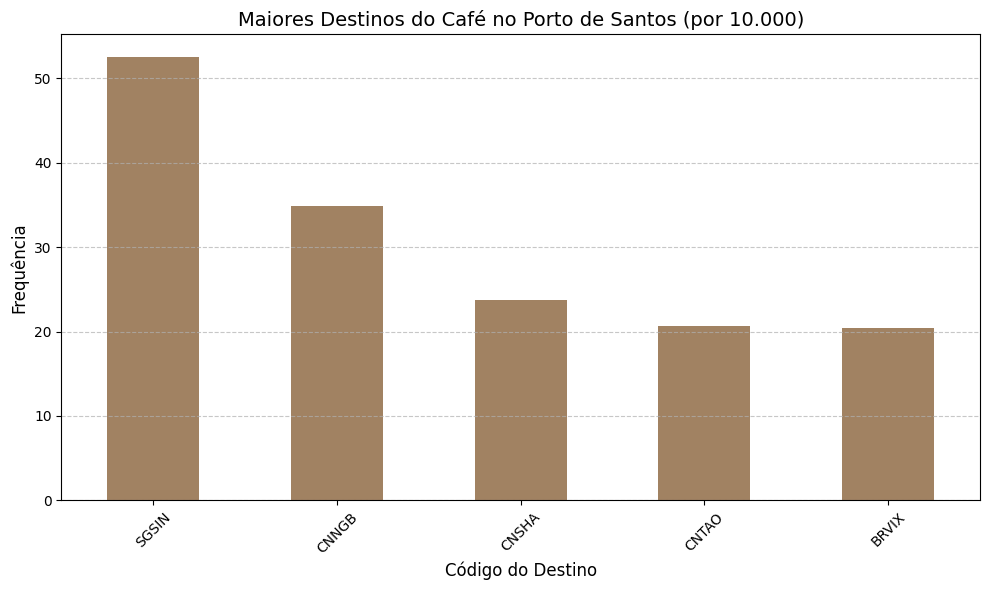

In [ ]:
plt.figure(figsize=(10, 6))
top_05_destinos_ajustados.plot(kind='bar', color='#a18262')

plt.title('Maiores Destinos do Café no Porto de Santos (por 10.000)', fontsize=14)
plt.xlabel('Código do Destino', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

1 - Singapore, Singapore (SGSIN)

2 - Ningbo, China (CNNGB)

3 - SHANGHAI, China (CNSHA)

4 - QINGDAO, China (CNTAO)

5 - Vitória, Brasil (BRVIX)

# Modelo Bayesiano para Estimar Probabilidade por Destino (Série Temporal)
Será utilizado as variáveis de: Ano, MesNUm, Destino, VLPesoCargaBruta com o objetivo de estimar a probabilidade de cada destino ser o mais frequente entre os 5 portos que mais recebem o café do Porto de Santos em termos de volume em um período específico.

- **Ano**: Ano da movimentação.
- **MesNum:** Mês da movimentação.
- **Destino:** Código do destino (variável categórica).
- **VLPesoCargaBruta:** Volume de carga bruta.

Portos:

1 - Port Klang, Malásia (MYPKG)

2 - Bremer, Alemanha (DEBRV)

3 - Navegantes, Brasil (BRSC008)

4 - Génova, Itália (ITGOA)

5 - Tanger Med, Marrocos (MAPTM)

In [ ]:
df_agg = df_oficial.groupby(['Ano', 'MesNum', 'Destino'])['VLPesoCargaBruta'].sum().reset_index()
df_agg['VLPesoCargaBruta'] = pd.to_numeric(df_agg['VLPesoCargaBruta'], errors='coerce')
df_agg = df_agg.dropna(subset=['VLPesoCargaBruta'])

In [ ]:
df_agg

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,Ano,MesNum,Destino,VLPesoCargaBruta
7,2018,1,BRFOR,2.300000e+02
9,2018,1,BRRIG,7.800000e+01
11,2018,1,BRSC008,4.444444e+14
36,2018,1,ILHFA,3.000000e+01
51,2018,1,TWKEL,2.500000e+02
...,...,...,...,...
8338,2022,11,BRVDC,6.010252e+07
8458,2022,12,BRVDC,1.956154e+07
8904,2023,4,AUADL,2.626263e+29
9928,2023,12,CMDLA,6.767677e+29


In [ ]:
anos_unicos = df_agg['Ano'].unique()
destinos_unicos = df_agg['Destino'].unique()

In [ ]:
anos_unicos

array([2018, 2019, 2020, 2021, 2022, 2023])

In [ ]:
destinos_unicos

array(['BRFOR', 'BRRIG', 'BRSC008', 'ILHFA', 'TWKEL', 'BRSSA', 'BRITJ',
       'FIHEL', 'HRPLE', 'MTMLA', 'MUPLU', 'BRIGI', 'PKBQM', 'ESVLC',
       'TWKHH', 'SADMN', 'JPNGO', 'CNSHG', 'AEAJM', 'AEAUH', 'AEJEA',
       'AESHJ', 'ALDRZ', 'AOLOB', 'ATSZG', 'AUBNE', 'AUMEL', 'AUSYD',
       'BDCGP', 'BGBOJ', 'BHBAH', 'BJCOO', 'CATOR', 'CDMAT', 'CIABJ',
       'CNCSX', 'CNCZX', 'CNFOC', 'CNHUA', 'CNJMN', 'CNLYG', 'CNNSA',
       'CNQZH', 'CNRZH', 'CNTSN', 'CNWUH', 'CNXMN', 'CNYNT', 'CNZJG',
       'CVRAI', 'DELEV', 'DENED', 'DESTG', 'DEWOE', 'DKAAR', 'DKCPH',
       'DZAAE', 'DZALG', 'DZORN', 'DZSKI', 'EETLL', 'EGALY', 'EGEDK',
       'ESBIO', 'ESCAS', 'ESGIJ', 'ESLEI', 'ESMLN', 'ESSCT', 'ESTAR',
       'ESVGO', 'FIKTK', 'FITOR', 'FRFOS', 'FRMTX', 'GBBEL', 'GBFXT',
       'GBKKB', 'GBSOU', 'GBTIL', 'GBWAY', 'GEBUS', 'GEPTI', 'GHTEM',
       'GNCKY', 'GRPIR', 'GRSKG', 'HRRJK', 'IDBLW', 'IDJKT', 'IDPLM',
       'IDSRG', 'IDSUB', 'ILASH', 'INBLR', 'INCCU', 'INCOK', 'INKNU',
       'INKRI', 'I

In [ ]:
df_pivot = df_agg.pivot_table(index=['Ano', 'MesNum'], columns='Destino', values='VLPesoCargaBruta', fill_value=0)
df_pivot

Destino          AEAJM   AEAUH         AEJEA        AESHJ  AGSJO     ALDRZ  \
Ano  MesNum                                                                  
2018 1             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     2             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     3             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     4             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     5             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     6             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     7             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     8             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     10            0.0     0.0  0.000000e+00          0.0    0.0       0.0   
2019 1             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     3       4152433.0   260.0  3.295663e+25       2757.0    0.0   65131.0   
     4          3125.0     0.0  2.956433e+21      31190.0    0.0  293296.0   
     5             0.0     0.0  1.881772e+11          0.0    0.0      30.0   
     6             4.0     0.0  9.780283e+08          0.0    0.0      57.0   
     7             0.0     0.0  2.928227e+45          0.0    0.0    5527.0   
     8             0.0   342.0  2.845979e+16         54.0    0.0       0.0   
     9             0.0     0.0  8.953731e+52       2656.0    0.0       0.0   
     10            0.0     0.0  1.155414e+21         24.0    0.0   17112.0   
     11           32.0     0.0  1.340736e+43    1252526.0    0.0      90.0   
     12            0.0     0.0  5.412522e+15       2252.0    0.0       0.0   
2020 1             0.0     0.0  2.005849e+19         85.0    0.0      17.0   
     2             0.0     0.0  9.335956e+42  572726185.0    0.0       0.0   
     3             0.0     0.0  9.992831e+36    5332106.0    0.0    2828.0   
     4             0.0     0.0  8.603351e+52    1567726.0    0.0       0.0   
     5             0.0     0.0  9.782686e+40       5325.0    0.0      17.0   
     6             0.0    29.0  2.119673e+26       4725.0    0.0      27.0   
     7             0.0    29.0  3.125779e+15     215730.0    0.0    2656.0   
     8             0.0     0.0  2.381297e+12      13655.0    0.0       0.0   
     9             0.0     0.0  1.764953e+12       2726.0    0.0     132.0   
     10            0.0  3030.0  4.228280e+05    2814284.0    0.0       0.0   
     11            0.0     0.0  5.742428e+10       2681.0    0.0   42154.0   
     12            0.0     0.0  9.956000e+03        140.0    0.0  533232.0   
2021 1             0.0     0.0  2.854293e+07       5128.0    0.0  532042.0   
     2             0.0     0.0  2.811884e+09       2880.0    0.0     113.0   
     3             0.0     0.0  3.470000e+02          0.0    0.0      42.0   
     4             0.0     0.0  2.900000e+01        167.0    0.0    4231.0   
     5             0.0    52.0  8.420115e+17   26553108.0    0.0      94.0   
     6             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     8             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     9             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
2022 1             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     5             0.0     0.0  0.000000e+00          0.0   23.0       0.0   
     6             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     8             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     11            0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     12            0.0     0.0  0.000000e+00          0.0    0.0       0.0   
2023 4             0.0     0.0  0.000000e+00          0.0    0.0       0.0   
     12            0.0     0.0  0.000000e+00          0.0    0.0       0.0   

Destino          AOLOB  AOMSZ  ARUSH  ARZAE  ...         VNSGN  VNUIH  \
Ano  MesNum               

In [ ]:
totais_por_porto = df_pivot.iloc[:, 2:].sum().sort_values(ascending=False)  # Do 3º ao último são os portos
totais_por_porto

,0
Destino,
MYPKG,4.631932e+303
DEBRV,2.938623e+303
BRSC008,2.222222e+299
ITGOA,2.776235e+296
MAPTM,3.281165e+221
...,...
GBSOU,5.000000e+00
IEORK,5.000000e+00
INBLR,4.000000e+00


In [ ]:
maiores_portos = totais_por_porto.head(5).index
maiores_portos

Index(['MYPKG', 'DEBRV', 'BRSC008', 'ITGOA', 'MAPTM'], dtype='object', name='Destino')

In [ ]:
df_pivot.index = pd.to_datetime(df_pivot.index.map(lambda x: f"{x[0]}-{x[1]:02d}"))
df_pivot

Destino,AEAJM,AEAUH,AEJEA,AESHJ,AGSJO,ALDRZ,AOLOB,AOMSZ,ARUSH,ARZAE,...,VNSGN,VNUIH,VNVUT,YEADE,YEMKX,ZACPT,ZADUR,ZAPLZ,ZAZBA,ZZZZZ
2018-01-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-02-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-03-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-04-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-05-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-06-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-07-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-08-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-10-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2019-01-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0


In [ ]:
df_pivot.index.name = 'Data'
df_pivot

Destino,AEAJM,AEAUH,AEJEA,AESHJ,AGSJO,ALDRZ,AOLOB,AOMSZ,ARUSH,ARZAE,...,VNSGN,VNUIH,VNVUT,YEADE,YEMKX,ZACPT,ZADUR,ZAPLZ,ZAZBA,ZZZZZ
Data,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-02-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-03-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-04-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-05-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-06-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-07-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-08-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2018-10-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0


In [ ]:
print(df_pivot.head())

Destino     AEAJM  AEAUH  AEJEA  AESHJ  AGSJO  ALDRZ  AOLOB  AOMSZ  ARUSH  \
Data                                                                        
2018-01-01    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2018-02-01    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2018-03-01    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2018-04-01    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2018-05-01    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

Destino     ARZAE  ...  VNSGN  VNUIH  VNVUT  YEADE  YEMKX  ZACPT  ZADUR  \
Data               ...                                                    
2018-01-01    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2018-02-01    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2018-03-01    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2018-04-01    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2018-05-01

In [ ]:
df_pivot = df_pivot.reset_index()
df_pivot

Destino,Data,AEAJM,AEAUH,AEJEA,AESHJ,AGSJO,ALDRZ,AOLOB,AOMSZ,ARUSH,...,VNSGN,VNUIH,VNVUT,YEADE,YEMKX,ZACPT,ZADUR,ZAPLZ,ZAZBA,ZZZZZ
0,2018-01-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
1,2018-02-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2,2018-03-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
3,2018-04-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
4,2018-05-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
5,2018-06-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
6,2018-07-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
7,2018-08-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
8,2018-10-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
9,2019-01-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0


In [ ]:
df_pivot['Ano'] = df_pivot['Data'].dt.year
df_pivot['MesNum'] = df_pivot['Data'].dt.month

In [ ]:
df_pivot

Destino,Data,AEAJM,AEAUH,AEJEA,AESHJ,AGSJO,ALDRZ,AOLOB,AOMSZ,ARUSH,...,VNVUT,YEADE,YEMKX,ZACPT,ZADUR,ZAPLZ,ZAZBA,ZZZZZ,Ano,MesNum
0,2018-01-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2018,1
1,2018-02-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2018,2
2,2018-03-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2018,3
3,2018-04-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2018,4
4,2018-05-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2018,5
5,2018-06-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2018,6
6,2018-07-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2018,7
7,2018-08-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2018,8
8,2018-10-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2018,10
9,2019-01-01,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2019,1


In [ ]:
df_long = df_pivot.melt(id_vars=['Data', 'Ano', 'MesNum'], value_vars=df_pivot.columns[1:],
                        var_name='Destino', value_name='VLPesoCargaBruta')
df_long

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,Data,Ano,MesNum,Destino,VLPesoCargaBruta
0,2018-01-01,2018,1,AEAJM,0.0
1,2018-02-01,2018,2,AEAJM,0.0
2,2018-03-01,2018,3,AEAJM,0.0
3,2018-04-01,2018,4,AEAJM,0.0
4,2018-05-01,2018,5,AEAJM,0.0
...,...,...,...,...,...
18427,2022-08-01,2022,8,ZZZZZ,0.0
18428,2022-11-01,2022,11,ZZZZZ,0.0
18429,2022-12-01,2022,12,ZZZZZ,0.0
18430,2023-04-01,2023,4,ZZZZZ,0.0


In [ ]:
maiores_portos

Index(['MYPKG', 'DEBRV', 'BRSC008', 'ITGOA', 'MAPTM'], dtype='object', name='Destino')

In [ ]:
df_long_filtrado = df_long[df_long['Destino'].isin(maiores_portos)]
df_long_filtrado

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,Data,Ano,MesNum,Destino,VLPesoCargaBruta
1536,2018-01-01,2018,1,BRSC008,4.444444e+14
1537,2018-02-01,2018,2,BRSC008,0.000000e+00
1538,2018-03-01,2018,3,BRSC008,0.000000e+00
1539,2018-04-01,2018,4,BRSC008,0.000000e+00
1540,2018-05-01,2018,5,BRSC008,0.000000e+00
...,...,...,...,...,...
12331,2022-08-01,2022,8,MYPKG,0.000000e+00
12332,2022-11-01,2022,11,MYPKG,0.000000e+00
12333,2022-12-01,2022,12,MYPKG,0.000000e+00
12334,2023-04-01,2023,4,MYPKG,0.000000e+00


In [ ]:
df_long_filtrado = df_long_filtrado.dropna(subset=['VLPesoCargaBruta'])
df_long_filtrado

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,Data,Ano,MesNum,Destino,VLPesoCargaBruta
1536,2018-01-01,2018,1,BRSC008,4.444444e+14
1537,2018-02-01,2018,2,BRSC008,0.000000e+00
1538,2018-03-01,2018,3,BRSC008,0.000000e+00
1539,2018-04-01,2018,4,BRSC008,0.000000e+00
1540,2018-05-01,2018,5,BRSC008,0.000000e+00
...,...,...,...,...,...
12331,2022-08-01,2022,8,MYPKG,0.000000e+00
12332,2022-11-01,2022,11,MYPKG,0.000000e+00
12333,2022-12-01,2022,12,MYPKG,0.000000e+00
12334,2023-04-01,2023,4,MYPKG,0.000000e+00


with model:
    trace = pm.sample(2000, init='adapt_diag')

## Análise do modelo

In [ ]:
import arviz as az

summary = az.summary(trace, var_names=['prob_destino', 'ano_coeff', 'mes_coeff'])
print(summary)

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
prob_destino[0]  0.003  0.003   0.000    0.008      0.000    0.000     123.0   
prob_destino[1]  0.003  0.003   0.000    0.008      0.000    0.000      44.0   
prob_destino[2]  0.002  0.002   0.000    0.006      0.000    0.000      37.0   
prob_destino[3]  0.003  0.003   0.000    0.008      0.001    0.000      20.0   
prob_destino[4]  0.003  0.003   0.000    0.007      0.000    0.000      51.0   
...                ...    ...     ...      ...        ...      ...       ...   
mes_coeff[381]   0.004  1.052  -1.970    1.978      0.099    0.070     116.0   
mes_coeff[382]  -0.056  1.123  -2.076    1.962      0.126    0.089      81.0   
mes_coeff[383]   0.062  1.021  -1.763    1.897      0.072    0.051     204.0   
mes_coeff[384]   0.086  0.994  -1.768    1.931      0.071    0.051     195.0   
mes_coeff[385]  -0.077  1.067  -1.890    2.033      0.110    0.078      95.0   

                 ess_tail  r_hat  
prob

Visualizar as distribuições posteriores dos parâmetros para entender como os dados informaram as probabilidades.


/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1158) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'prob_destino\n0'}>,
        <Axes: title={'center': 'prob_destino\n1'}>,
        <Axes: title={'center': 'prob_destino\n2'}>,
        <Axes: title={'center': 'prob_destino\n3'}>],
       [<Axes: title={'center': 'prob_destino\n4'}>,
        <Axes: title={'center': 'prob_destino\n5'}>,
        <Axes: title={'center': 'prob_destino\n6'}>,
        <Axes: title={'center': 'prob_destino\n7'}>],
       [<Axes: title={'center': 'prob_destino\n8'}>,
        <Axes: title={'center': 'prob_destino\n9'}>,
        <Axes: title={'center': 'prob_destino\n10'}>,
        <Axes: title={'center': 'prob_destino\n11'}>],
       [<Axes: title={'center': 'prob_destino\n12'}>,
        <Axes: title={'center': 'prob_destino\n13'}>,
        <Axes: title={'center': 'prob_destino\n14'}>,
        <Axes: title={'center': 'prob_destino\n15'}>],
       [<Axes: title={'center': 'prob_destino\n16'}>,
        <Axes: title={'center': 'prob_destino\n17'}>,
        <Axes: title={'center': 'p

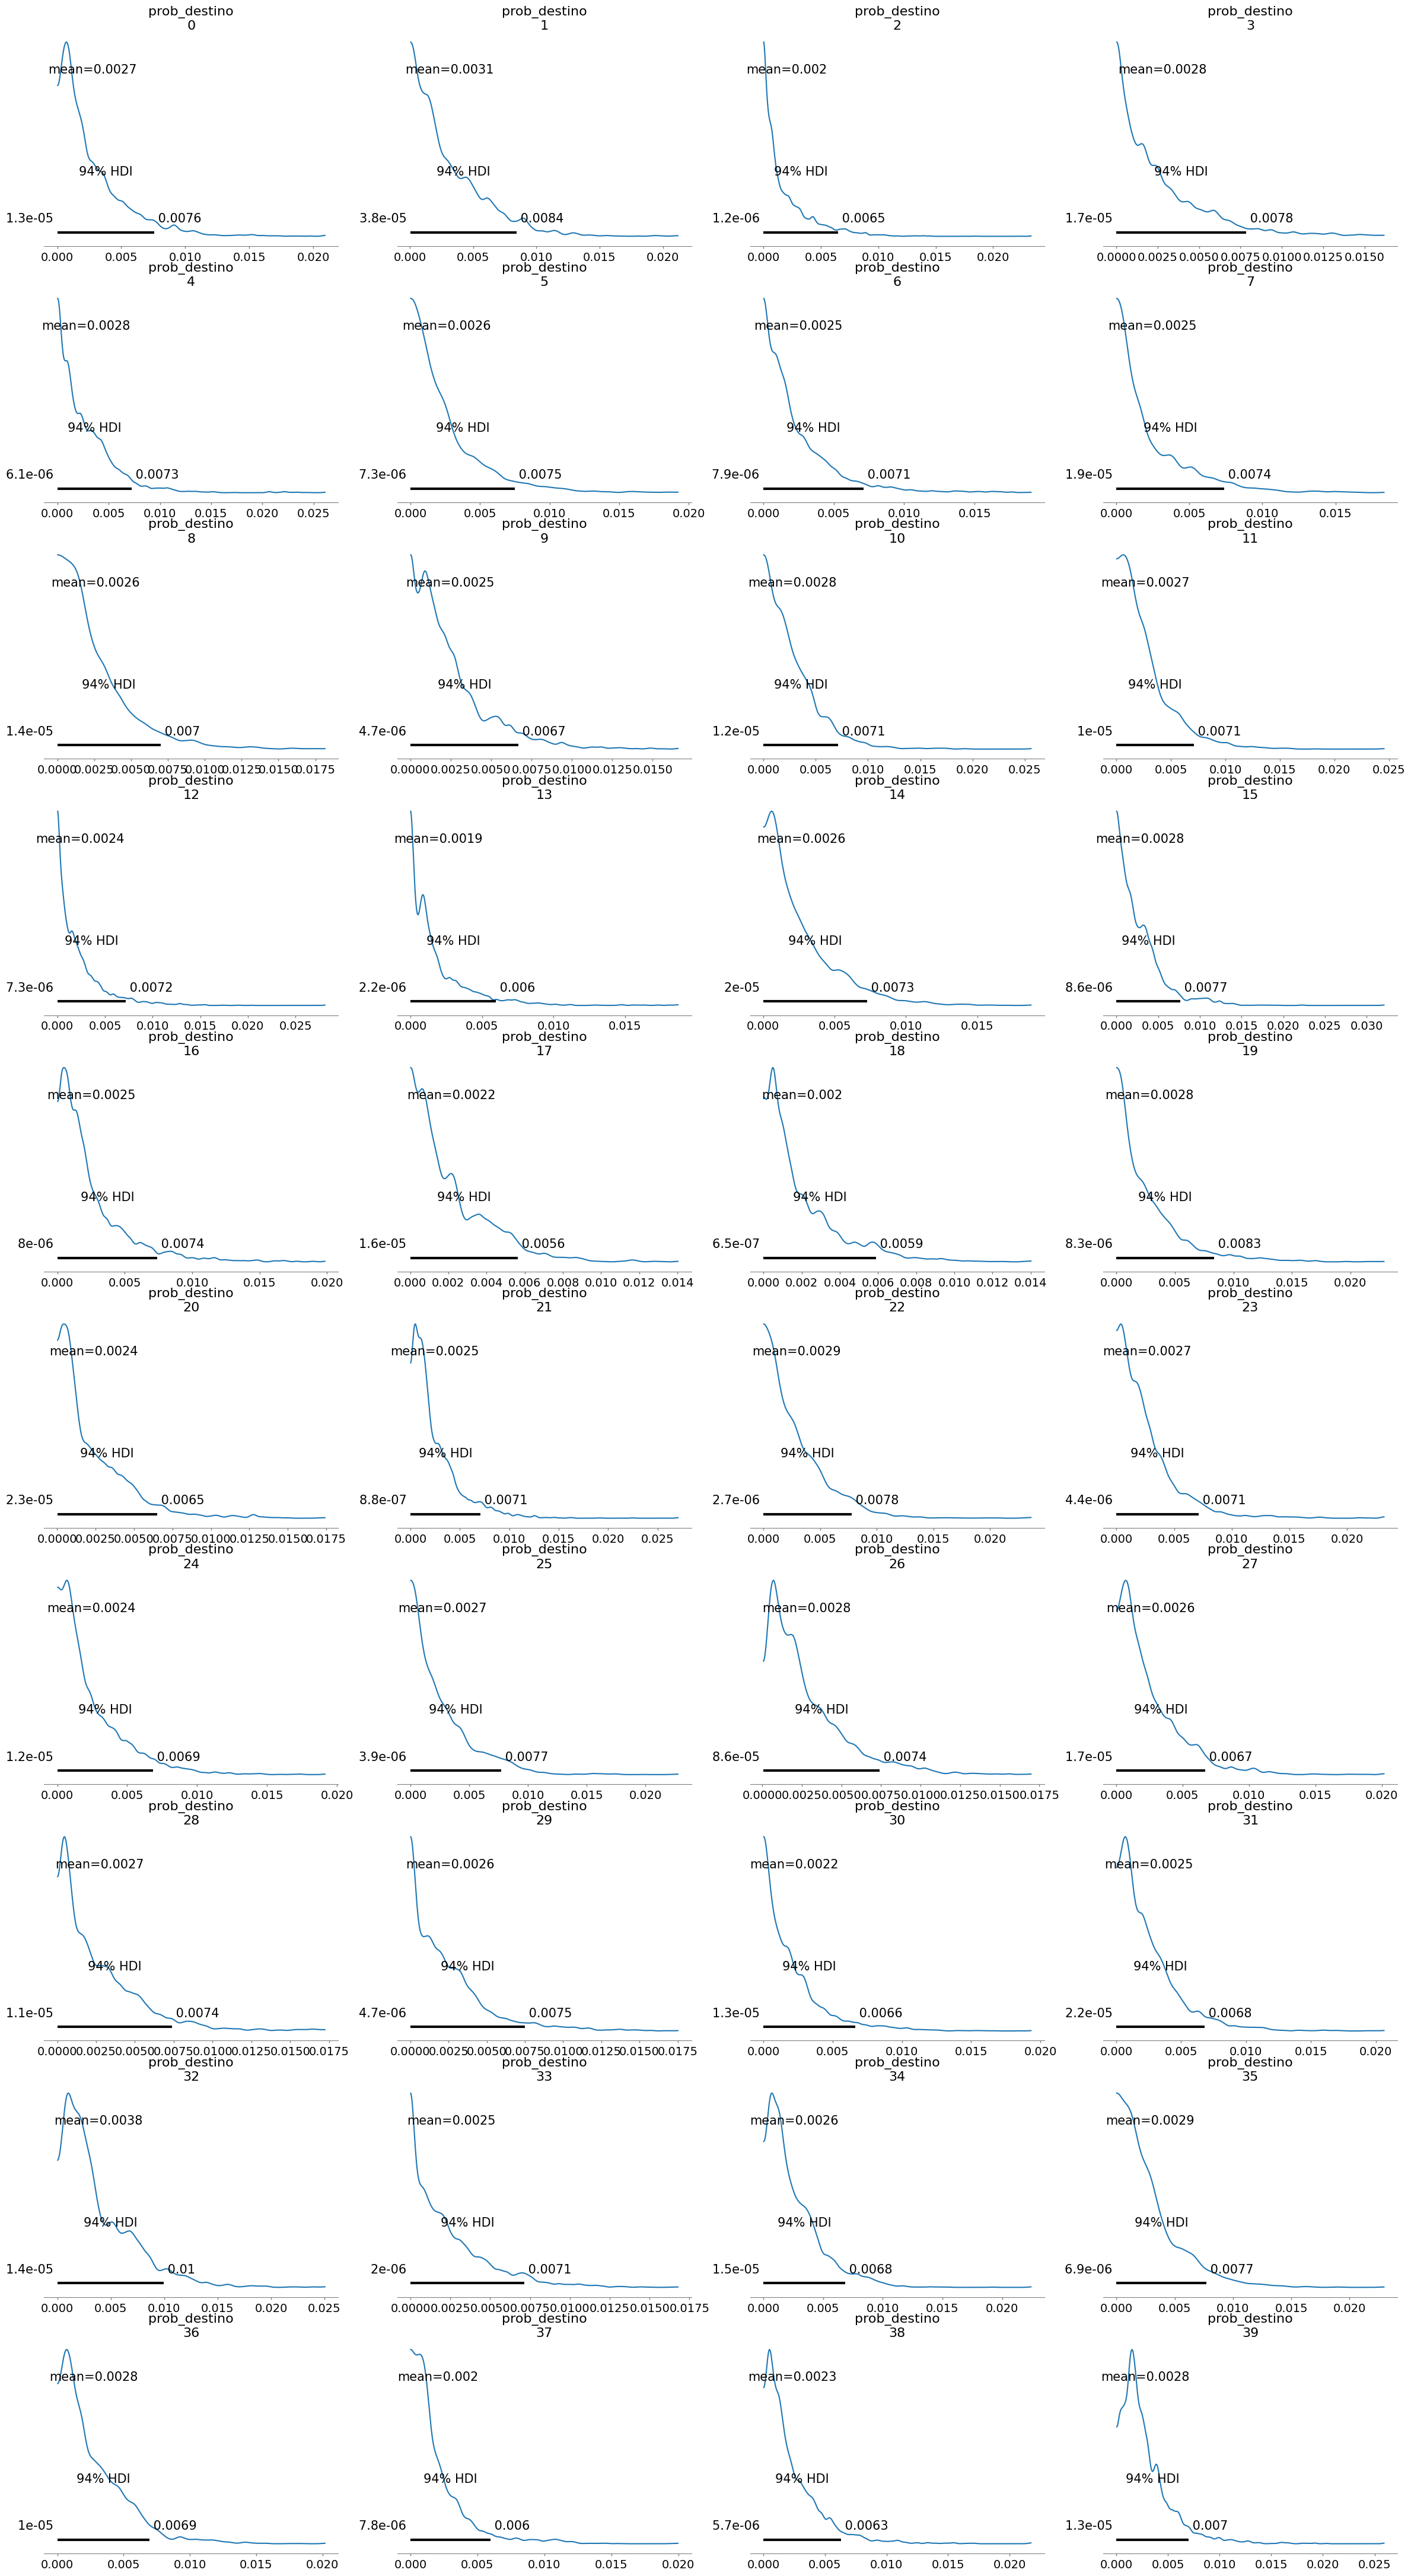

In [ ]:
az.plot_posterior(trace, var_names=['prob_destino', 'ano_coeff', 'mes_coeff'])

Traceplots para verificar a mistura dos traços. Mistura ruim (como padrões repetitivos) pode indicar problemas de convergência.

array([[<Axes: title={'center': 'prob_destino'}>,
        <Axes: title={'center': 'prob_destino'}>],
       [<Axes: title={'center': 'ano_coeff'}>,
        <Axes: title={'center': 'ano_coeff'}>],
       [<Axes: title={'center': 'mes_coeff'}>,
        <Axes: title={'center': 'mes_coeff'}>]], dtype=object)

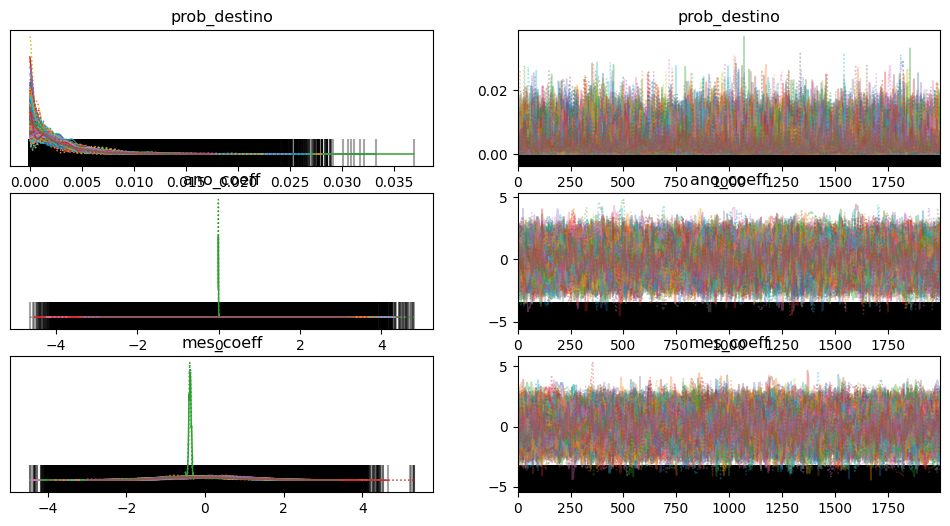

In [ ]:
az.plot_trace(trace, var_names=['prob_destino', 'ano_coeff', 'mes_coeff'])

In [ ]:
with model:
    posterior_pred = pm.sample_posterior_predictive(trace)

Output()

In [ ]:
posterior_pred

Inference data with groups:
	> posterior_predictive
	> observed_data

In [ ]:
posterior_samples = posterior_pred.posterior_predictive['destino_obs'].values

print(posterior_samples.shape)


(2, 2000, 240)


### Histograma das predições

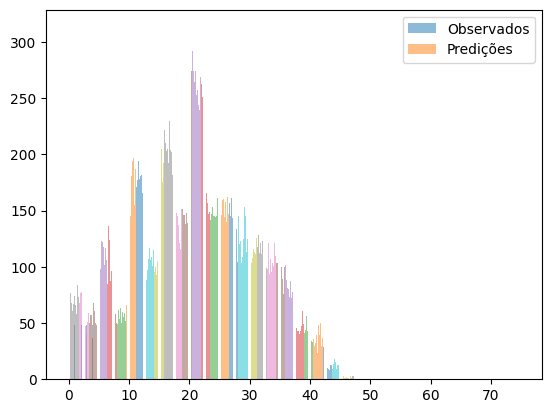

In [ ]:
plt.hist(df_long_filtrado['Destino'].astype('category').cat.codes, bins=30, alpha=0.5, label='Observados')

plt.hist(np.mean(posterior_samples, axis=0), bins=30, alpha=0.5, label='Predições')
plt.legend()
plt.show()

Observados: A distribuição apresenta uma concentração maior em valores menores, indicando que certos destinos são mais frequentes.

Predições: As barras seguem um padrão similar ao dos dados observados, sugerindo que o modelo captura bem a distribuição geral. Porém, pode haver diferenças em destinos menos frequentes.

### Predições com Intervalos de Incerteza
Predições do modelo com intervalos de credibilidade. Isso ajuda a entender a incerteza associada às predições para cada destino ao longo do tempo.


In [ ]:
pred_means = np.mean(posterior_samples, axis=0)
pred_hpd = az.hdi(posterior_samples, hdi_prob=0.95)

In [ ]:
pred_means_ajustado = pred_means.mean(axis=0)
pred_hpd_ajustado = az.hdi(pred_means, hdi_prob=0.95)

<ipython-input-41-ea92b18de464>:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hpd_ajustado = az.hdi(pred_means, hdi_prob=0.95)


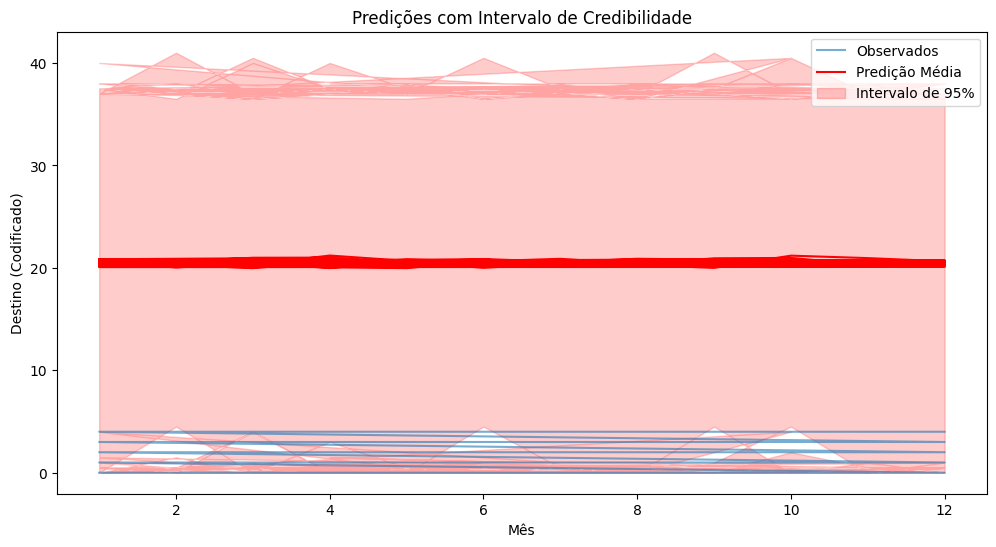

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_long_filtrado['MesNum'], df_long_filtrado['Destino'].astype('category').cat.codes, label="Observados", alpha=0.6)
plt.plot(df_long_filtrado['MesNum'], pred_means_ajustado, label="Predição Média", color="red")
plt.fill_between(df_long_filtrado['MesNum'], pred_hpd_ajustado[:, 0], pred_hpd_ajustado[:, 1], color="red", alpha=0.2, label="Intervalo de 95%")
plt.xlabel("Mês")
plt.ylabel("Destino (Codificado)")
plt.legend()
plt.title("Predições com Intervalo de Credibilidade")
plt.show()

O gráfico exibe a variação dos destinos ao longo dos meses com predições médias e intervalos de 95%:

Linha Azul: Representa os destinos observados (codificados).
Linha Vermelha: Mostra a predição média do modelo.

Área Vermelha Clara: Intervalo de credibilidade de 95%, indicando a incerteza do modelo.

A discrepância entre os observados e a predição média pode apontar onde o modelo não está capturando padrões sazonais ou mudanças nos dados. A sobreposição do intervalo de 95% sobre as observações indica que o modelo é robusto em prever destinos mais frequentes.

### Gráficos de Série Temporal com Probabilidades por Destino
Gráfico de área empilhada para mostrar a distribuição de probabilidades de cada destino ao longo do tempo.


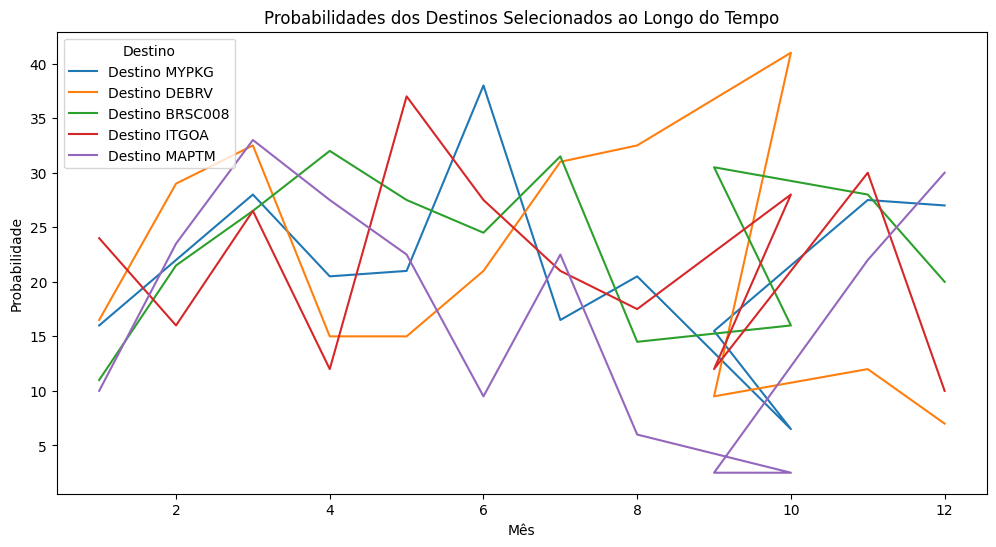

In [ ]:
# Destinos que você deseja visualizar
destinos_selecionados = ['MYPKG', 'DEBRV', 'BRSC008', 'ITGOA', 'MAPTM']
destinos_idx = [df_long_filtrado['Destino'].unique().tolist().index(destino) for destino in destinos_selecionados]

# Plot das probabilidades médias por destino
plt.figure(figsize=(12, 6))
for destino_idx in destinos_idx:  # Iterar sobre os destinos selecionados
    plt.plot(
        df_long_filtrado['MesNum'].unique(),  # Usar valores únicos de mês
        prob_destinos_mensal[:, destino_idx],  # Probabilidade para o destino selecionado
        label=f"Destino {destinos_selecionados[destinos_idx.index(destino_idx)]}"  # Nome do destino
    )

plt.xlabel("Mês")
plt.ylabel("Probabilidade")
plt.legend(title="Destino", loc="upper left")
plt.title("Probabilidades dos Destinos Selecionados ao Longo do Tempo")
plt.show()


Este gráfico foca nos cinco principais destinos (MYPKG, DEBRV, BRSC008, ITGOA, MAPTM) e mostra a variação das probabilidades ao longo do tempo:

Linhas Coloridas: Cada linha representa um destino e sua probabilidade mensal.

Análise Sazonal: A variação nas probabilidades sugere padrões sazonais específicos para cada destino, com alguns apresentando picos em determinados meses.

Destaques:

MYPKG e MAPTM mostram flutuações mais suaves.

DEBRV, ITGOA e BRSC008 têm variações mais abruptas, sugerindo eventos ou padrões mensais mais específicos.